In [1]:
import tensorflow

from tensorflow.python.client import device_lib

device_lib.list_local_devices()

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4612198253098987437, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11324823962
 locality {
   bus_id: 1
 }
 incarnation: 9584459300930961766
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"]

In [2]:
import keras
keras.__version__

Using TensorFlow backend.


'2.1.2'

In [3]:
!unzip train.zip
!mv train kaggle_train

Archive:  train.zip
   creating: train/
  inflating: train/84da76f5.jpg      
  inflating: train/d5c9c1f2.jpg      
  inflating: train/943cb663.jpg      
  inflating: train/906c534e.jpg      
  inflating: train/cca9cd4e.jpg      
  inflating: train/dabfedb4.jpg      
  inflating: train/07b8b278.jpg      
  inflating: train/c3b79ec4.jpg      
  inflating: train/a549a05f.jpg      
  inflating: train/d87e29dc.jpg      
  inflating: train/dfee01f1.jpg      
  inflating: train/74861c16.jpg      
  inflating: train/6ee9e357.jpg      
  inflating: train/0caa3541.jpg      
  inflating: train/fff04277.jpg      
  inflating: train/d2796dc6.jpg      
  inflating: train/cd656086.jpg      
  inflating: train/04a91387.jpg      
  inflating: train/374aaece.jpg      
  inflating: train/eef1c346.jpg      
  inflating: train/3b4495e4.jpg      
  inflating: train/1d35c098.jpg      
  inflating: train/f87447c6.jpg      
  inflating: train/c87be503.jpg      
  inflating: train/345382b4.jpg      
  inflatin

  inflating: train/18ef4f06.jpg      
  inflating: train/76db543d.jpg      
  inflating: train/983d31f6.jpg      
  inflating: train/c9dd23b9.jpg      
  inflating: train/fb578eda.jpg      
  inflating: train/c237b34a.jpg      
  inflating: train/f229f39a.jpg      
  inflating: train/977bb032.jpg      
  inflating: train/6312252d.jpg      
  inflating: train/f72af9d9.jpg      
  inflating: train/06b55250.jpg      
  inflating: train/b644e786.jpg      
  inflating: train/3033ec6e.jpg      
  inflating: train/e066c182.jpg      
  inflating: train/b2e3c977.jpg      
  inflating: train/418bc03d.jpg      
  inflating: train/f4bc2ee9.jpg      
  inflating: train/f2d9b75f.jpg      
  inflating: train/87050167.jpg      
  inflating: train/839c3cc3.jpg      
  inflating: train/88b9c870.jpg      
  inflating: train/9b462c30.jpg      
  inflating: train/fd179440.jpg      
  inflating: train/d510d70f.jpg      
  inflating: train/4db1eae2.jpg      
  inflating: train/ed697660.jpg      
  inflating:

  inflating: train/8a02ac88.jpg      
  inflating: train/a8ea96dd.jpg      
  inflating: train/c5629e60.jpg      
  inflating: train/438e25a5.jpg      
  inflating: train/0c88a7aa.jpg      
  inflating: train/4bab06de.jpg      
  inflating: train/f5148700.jpg      
  inflating: train/58207919.jpg      
  inflating: train/57e05044.jpg      
  inflating: train/29c09432.jpg      
  inflating: train/8577508d.jpg      
  inflating: train/cd6f2df1.jpg      
  inflating: train/a8b159a2.jpg      
  inflating: train/79fa89c7.jpg      
  inflating: train/43f45ef3.jpg      
  inflating: train/b638d3ac.jpg      
  inflating: train/6d2adda7.jpg      
  inflating: train/2b47d3f8.jpg      
  inflating: train/c12bc9e7.jpg      
  inflating: train/3e793658.jpg      
  inflating: train/c2f5f0a6.jpg      
  inflating: train/aba31a94.jpg      
  inflating: train/b1e60ef3.jpg      
  inflating: train/989846a8.jpg      
  inflating: train/8e99717a.jpg      
  inflating: train/ad24a59c.jpg      
  inflating:

  inflating: train/cba74978.jpg      
  inflating: train/05f7a40d.jpg      
  inflating: train/0d614401.jpg      
  inflating: train/fd9fac4d.jpg      
  inflating: train/115979f2.jpg      
  inflating: train/e96978ce.jpg      
  inflating: train/cadc5708.jpg      
  inflating: train/1491b7b7.jpg      
  inflating: train/ddb8f7bf.jpg      
  inflating: train/70d6bf9e.jpg      
  inflating: train/eaa07cb8.jpg      
  inflating: train/e7c551ac.jpg      
  inflating: train/04c73b64.jpg      
  inflating: train/691bd223.jpg      
  inflating: train/bd96fb0b.jpg      
  inflating: train/aaead8b8.jpg      
  inflating: train/e50f1a29.jpg      
  inflating: train/238ae4f1.jpg      
  inflating: train/21c7c959.jpg      
  inflating: train/ea31616f.jpg      
  inflating: train/50b4bbc4.jpg      
  inflating: train/70953372.jpg      
  inflating: train/9f52074b.jpg      
  inflating: train/817f06d1.jpg      
  inflating: train/02e6188b.jpg      
  inflating: train/cd91f5d4.jpg      
  inflating:

  inflating: train/b44c2902.jpg      
  inflating: train/c1bd0ce1.jpg      
  inflating: train/e3bcf806.jpg      
  inflating: train/ef7fd01e.jpg      
  inflating: train/e11852f2.jpg      
  inflating: train/79a92667.jpg      
  inflating: train/cf1c6ca4.jpg      
  inflating: train/098da275.jpg      
  inflating: train/94b209e6.jpg      
  inflating: train/5114596e.jpg      
  inflating: train/e8fef570.jpg      
  inflating: train/200b53a2.jpg      
  inflating: train/7303047f.jpg      
  inflating: train/3de64c05.jpg      
  inflating: train/a1513532.jpg      
  inflating: train/56bf66a8.jpg      
  inflating: train/0fb6482b.jpg      
  inflating: train/c1bac2aa.jpg      
  inflating: train/e1f4825b.jpg      
  inflating: train/01be6c48.jpg      
  inflating: train/bbfef63f.jpg      
  inflating: train/4570aff9.jpg      
  inflating: train/90a33116.jpg      
  inflating: train/30b17ff4.jpg      
  inflating: train/7cf99855.jpg      
  inflating: train/baa95c38.jpg      
  inflating:

  inflating: train/50e6f606.jpg      
  inflating: train/37236044.jpg      
  inflating: train/e66606f9.jpg      
  inflating: train/70577256.jpg      
  inflating: train/0fa2da8f.jpg      
  inflating: train/248dd355.jpg      
  inflating: train/b74e0a23.jpg      
  inflating: train/bc534671.jpg      
  inflating: train/52aa5f95.jpg      
  inflating: train/b80ab566.jpg      
  inflating: train/01e37453.jpg      
  inflating: train/f233ed87.jpg      
  inflating: train/02715625.jpg      
  inflating: train/2f87bbcf.jpg      
  inflating: train/10eb1d8b.jpg      
  inflating: train/7668456a.jpg      
  inflating: train/1ae99bfc.jpg      
  inflating: train/24bfe09c.jpg      
  inflating: train/cd7df1f7.jpg      
  inflating: train/fcf03ecc.jpg      
  inflating: train/8f5bba90.jpg      
  inflating: train/a701a8e4.jpg      
  inflating: train/a459efb3.jpg      
  inflating: train/63d2568f.jpg      
  inflating: train/2f278e2e.jpg      
  inflating: train/8a5667a6.jpg      
  inflating:

  inflating: train/9b0be739.jpg      
  inflating: train/2dda4194.jpg      
  inflating: train/30735e71.jpg      
  inflating: train/f30f4763.jpg      
  inflating: train/69943d01.jpg      
  inflating: train/e4ea5138.jpg      
  inflating: train/246db1e2.jpg      
  inflating: train/877aba70.jpg      
  inflating: train/527d971d.jpg      
  inflating: train/91ed850e.jpg      
  inflating: train/28c1ad3c.jpg      
  inflating: train/48db6b1c.jpg      
  inflating: train/815d7663.jpg      
  inflating: train/9cf24fb5.jpg      
  inflating: train/a0f170a8.jpg      
  inflating: train/8f62eea0.jpg      
  inflating: train/d3050057.jpg      
  inflating: train/dd2abc18.jpg      
  inflating: train/634a621e.jpg      
  inflating: train/bb95262c.jpg      
  inflating: train/3ac35396.jpg      
  inflating: train/aefffd67.jpg      
  inflating: train/abb34e87.jpg      
  inflating: train/667848df.jpg      
  inflating: train/15033ddb.jpg      
  inflating: train/2e08f2ba.jpg      
  inflating:

  inflating: train/a8dc3377.jpg      
  inflating: train/7d863f5f.jpg      
  inflating: train/f999659f.jpg      
  inflating: train/39ff73b1.jpg      
  inflating: train/376ec81c.jpg      
  inflating: train/50576f5f.jpg      
  inflating: train/c941efe9.jpg      
  inflating: train/737a5429.jpg      
  inflating: train/1990152d.jpg      
  inflating: train/5d13f1bf.jpg      
  inflating: train/8b474833.jpg      
  inflating: train/bfd11a00.jpg      
  inflating: train/b259d455.jpg      
  inflating: train/d4d69698.jpg      
  inflating: train/aa9e501c.jpg      
  inflating: train/43cfbe67.jpg      
  inflating: train/17cc96e5.jpg      
  inflating: train/400f59b3.jpg      
  inflating: train/75839c23.jpg      
  inflating: train/73e81ae9.jpg      
  inflating: train/fed3bc99.jpg      
  inflating: train/e57c204a.jpg      
  inflating: train/86e00b40.jpg      
  inflating: train/c7dcc032.jpg      
  inflating: train/c160d37a.jpg      
  inflating: train/928e71a4.jpg      
  inflating:

  inflating: train/5596e225.jpg      
  inflating: train/395eafc8.jpg      
  inflating: train/94ace974.jpg      
  inflating: train/f5930905.jpg      
  inflating: train/8f0109bc.jpg      
  inflating: train/602901f8.jpg      
  inflating: train/258cdcdc.jpg      
  inflating: train/ddf1016b.jpg      
  inflating: train/70a02704.jpg      
  inflating: train/2f2a3421.jpg      
  inflating: train/51944888.jpg      
  inflating: train/0fcbbfeb.jpg      
  inflating: train/5207af07.jpg      
  inflating: train/29aac49f.jpg      
  inflating: train/a176d744.jpg      
  inflating: train/3e3e2695.jpg      
  inflating: train/78a24a5d.jpg      
  inflating: train/2b4826af.jpg      
  inflating: train/bc479acb.jpg      
  inflating: train/3be73377.jpg      
  inflating: train/a91c827d.jpg      
  inflating: train/0eb0a241.jpg      
  inflating: train/98b1bb3a.jpg      
  inflating: train/d14090c9.jpg      
  inflating: train/e7df9a69.jpg      
  inflating: train/f3400e7e.jpg      
  inflating:

  inflating: train/599df708.jpg      
  inflating: train/5600a8e9.jpg      
  inflating: train/a168bab6.jpg      
  inflating: train/92d931b0.jpg      
  inflating: train/762e22f2.jpg      
  inflating: train/1d5bd8f0.jpg      
  inflating: train/0e74c12b.jpg      
  inflating: train/e82f0fad.jpg      
  inflating: train/7fd678f9.jpg      
  inflating: train/1fb83e23.jpg      
  inflating: train/33374e14.jpg      
  inflating: train/cd2a05ad.jpg      
  inflating: train/e9eb2fe4.jpg      
  inflating: train/77c9cd3b.jpg      
  inflating: train/accb1a0e.jpg      
  inflating: train/07b7d9ca.jpg      
  inflating: train/0466ed01.jpg      
  inflating: train/9ba64fae.jpg      
  inflating: train/57ea3876.jpg      
  inflating: train/7b0251fb.jpg      
  inflating: train/efac35b7.jpg      
  inflating: train/91a135b5.jpg      
  inflating: train/a4397c67.jpg      
  inflating: train/2eb590c7.jpg      
  inflating: train/f7bf8ae9.jpg      
  inflating: train/8af9064c.jpg      
  inflating:

  inflating: train/fabfd54e.jpg      
  inflating: train/d209b473.jpg      
  inflating: train/91052943.jpg      
  inflating: train/67264464.jpg      
  inflating: train/0870fa6b.jpg      
  inflating: train/442005d4.jpg      
  inflating: train/5fbe37d7.jpg      
  inflating: train/edab6020.jpg      
  inflating: train/bcce2421.jpg      
  inflating: train/f3999759.jpg      
  inflating: train/6f4a3b50.jpg      
  inflating: train/5f207948.jpg      
  inflating: train/8fe14533.jpg      
  inflating: train/f6327668.jpg      
  inflating: train/729f7ec3.jpg      
  inflating: train/2a56b270.jpg      
  inflating: train/dd6ed8bb.jpg      
  inflating: train/e8240f7b.jpg      
  inflating: train/73f1e015.jpg      
  inflating: train/20594d9d.jpg      
  inflating: train/546d8aee.jpg      
  inflating: train/e8862ff2.jpg      
  inflating: train/7877deea.jpg      
  inflating: train/8f8c20fa.jpg      
  inflating: train/aab30af5.jpg      
  inflating: train/d982ca00.jpg      
  inflating:

  inflating: train/cb306dae.jpg      
  inflating: train/6b0112b9.jpg      
  inflating: train/b576dfea.jpg      
  inflating: train/0fc584fc.jpg      
  inflating: train/51af5194.jpg      
  inflating: train/8b0e1a97.jpg      
  inflating: train/e26637c1.jpg      
  inflating: train/569a857d.jpg      
  inflating: train/428e5bcb.jpg      
  inflating: train/d01205cf.jpg      
  inflating: train/3f3703f5.jpg      
  inflating: train/9f9dbf24.jpg      
  inflating: train/ce4c721f.jpg      
  inflating: train/fa29b1d9.jpg      
  inflating: train/252cb6f2.jpg      
  inflating: train/3cc95165.jpg      
  inflating: train/7caf3e02.jpg      
  inflating: train/58a457cf.jpg      
  inflating: train/ed036c70.jpg      
  inflating: train/b3e36eb5.jpg      
  inflating: train/ee31d05e.jpg      
  inflating: train/d960969a.jpg      
  inflating: train/6df19410.jpg      
  inflating: train/7e7286d9.jpg      
  inflating: train/05651187.jpg      
  inflating: train/48773642.jpg      
  inflating:

  inflating: train/b8c84b33.jpg      
  inflating: train/27372869.jpg      
  inflating: train/cbf613cc.jpg      
  inflating: train/d7ed71b2.jpg      
  inflating: train/48c53a6c.jpg      
  inflating: train/bb79d3f1.jpg      
  inflating: train/d404ad13.jpg      
  inflating: train/64c8b970.jpg      
  inflating: train/0c0f34f2.jpg      
  inflating: train/33db4a84.jpg      
  inflating: train/4a986602.jpg      
  inflating: train/7b69408e.jpg      
  inflating: train/bdaeba7c.jpg      
  inflating: train/c35748a7.jpg      
  inflating: train/335a7987.jpg      
  inflating: train/98746ad3.jpg      
  inflating: train/733a8791.jpg      
  inflating: train/939e6b16.jpg      
  inflating: train/756e12d0.jpg      
  inflating: train/70212654.jpg      
  inflating: train/005c57e7.jpg      
  inflating: train/7b2ab7f3.jpg      
  inflating: train/7cef34e9.jpg      
  inflating: train/b3724b2d.jpg      
  inflating: train/4a3f5474.jpg      
  inflating: train/a0a69a4c.jpg      
  inflating:

  inflating: train/08593f8e.jpg      
  inflating: train/b6b66ef0.jpg      
  inflating: train/2ff1d55b.jpg      
  inflating: train/2ff5f524.jpg      
  inflating: train/c1a9b238.jpg      
  inflating: train/a66829bd.jpg      
  inflating: train/7fc79156.jpg      
  inflating: train/7475eba9.jpg      
  inflating: train/21427f0b.jpg      
  inflating: train/a1c702c0.jpg      
  inflating: train/d7d4e089.jpg      
  inflating: train/171b6d0f.jpg      
  inflating: train/c50de929.jpg      
  inflating: train/3d46b918.jpg      
  inflating: train/84e9fc47.jpg      
  inflating: train/9c8f9eab.jpg      
  inflating: train/4a880271.jpg      
  inflating: train/2240d494.jpg      
  inflating: train/e9c0d565.jpg      
  inflating: train/1fa1626d.jpg      
  inflating: train/f4195276.jpg      
  inflating: train/396abf42.jpg      
  inflating: train/ee4255cc.jpg      
  inflating: train/2af4d9b7.jpg      
  inflating: train/03b4ea17.jpg      
  inflating: train/9c2ba7b4.jpg      
  inflating:

  inflating: train/6af9f8fe.jpg      
  inflating: train/0eff71ec.jpg      
  inflating: train/95c1346f.jpg      
  inflating: train/422d9bfd.jpg      
  inflating: train/d939f00a.jpg      
  inflating: train/2f475559.jpg      
  inflating: train/fdaeed3f.jpg      
  inflating: train/9da81b62.jpg      
  inflating: train/6b4d1869.jpg      
  inflating: train/2027722b.jpg      
  inflating: train/7f995302.jpg      
  inflating: train/43301acf.jpg      
  inflating: train/9049ddfd.jpg      
  inflating: train/13d21461.jpg      
  inflating: train/8224f7c6.jpg      
  inflating: train/815718e9.jpg      
  inflating: train/2a63001b.jpg      
  inflating: train/d1f7fec7.jpg      
  inflating: train/356a6fef.jpg      
  inflating: train/9c1b05cb.jpg      
  inflating: train/a87fbdc0.jpg      
  inflating: train/34333c52.jpg      
  inflating: train/dd5bcda3.jpg      
  inflating: train/af835211.jpg      
  inflating: train/398b4166.jpg      
  inflating: train/0f83217e.jpg      
  inflating:

  inflating: train/7ac80e97.jpg      
  inflating: train/ac79a629.jpg      
  inflating: train/e9b1391c.jpg      
  inflating: train/178872f3.jpg      
  inflating: train/3460efe8.jpg      
  inflating: train/f75c5abe.jpg      
  inflating: train/294a6349.jpg      
  inflating: train/7cbb4d0e.jpg      
  inflating: train/05ef7149.jpg      
  inflating: train/f3e39b20.jpg      
  inflating: train/49f2db76.jpg      
  inflating: train/d18713d4.jpg      
  inflating: train/a9827190.jpg      
  inflating: train/f0a33ade.jpg      
  inflating: train/7b32738c.jpg      
  inflating: train/a21f1c30.jpg      
  inflating: train/aa420371.jpg      
  inflating: train/e44fceff.jpg      
  inflating: train/40e1012f.jpg      
  inflating: train/d7bb025c.jpg      
  inflating: train/2ab8c42d.jpg      
  inflating: train/d200f288.jpg      
  inflating: train/a89100c4.jpg      
  inflating: train/688aa961.jpg      
  inflating: train/bdf0a857.jpg      
  inflating: train/32eec8a0.jpg      
  inflating:

  inflating: train/b8ce9810.jpg      
  inflating: train/f65d31db.jpg      
  inflating: train/39f1f7f5.jpg      
  inflating: train/f2cf3e3f.jpg      
  inflating: train/9ea28e8f.jpg      
  inflating: train/bc59676f.jpg      
  inflating: train/54493726.jpg      
  inflating: train/5b36393d.jpg      
  inflating: train/cf54d154.jpg      
  inflating: train/5be8a441.jpg      
  inflating: train/ea2256c4.jpg      
  inflating: train/38ff2803.jpg      
  inflating: train/c7b52a6a.jpg      
  inflating: train/440d5063.jpg      
  inflating: train/ccc9abf7.jpg      
  inflating: train/e7283f1b.jpg      
  inflating: train/3fed5a16.jpg      
  inflating: train/df5fa71c.jpg      
  inflating: train/088cc3cc.jpg      
  inflating: train/50714eb5.jpg      
  inflating: train/b38550be.jpg      
  inflating: train/94f21a58.jpg      
  inflating: train/843bfdf1.jpg      
  inflating: train/64ee361c.jpg      
  inflating: train/def1b8b3.jpg      
  inflating: train/6a7542ac.jpg      
  inflating:

  inflating: train/0c11fa0c.jpg      
  inflating: train/e1eba938.jpg      
  inflating: train/9677485c.jpg      
  inflating: train/45966756.jpg      
  inflating: train/ac02167b.jpg      
  inflating: train/df7b8a5e.jpg      
  inflating: train/a6d0e8a5.jpg      
  inflating: train/dc17aafb.jpg      
  inflating: train/188446bc.jpg      
  inflating: train/f27adaf7.jpg      
  inflating: train/7165f410.jpg      
  inflating: train/651e8a21.jpg      
  inflating: train/7ddecfc2.jpg      
  inflating: train/ccf8ae42.jpg      
  inflating: train/b0109f7e.jpg      
  inflating: train/677c2196.jpg      
  inflating: train/b76a4ab9.jpg      
  inflating: train/9439664d.jpg      
  inflating: train/fbb679be.jpg      
  inflating: train/307d8841.jpg      
  inflating: train/64141b01.jpg      
  inflating: train/04d2b8a3.jpg      
  inflating: train/1a26e97b.jpg      
  inflating: train/2351aaea.jpg      
  inflating: train/a733423a.jpg      
  inflating: train/4bb35b66.jpg      
  inflating:

  inflating: train/95d6440c.jpg      
  inflating: train/081a21e1.jpg      
  inflating: train/2fbfd185.jpg      
  inflating: train/2b941c3b.jpg      
  inflating: train/573147f6.jpg      
  inflating: train/cfa397ce.jpg      
  inflating: train/44f9bfe0.jpg      
  inflating: train/7661d45e.jpg      
  inflating: train/3ef56efd.jpg      
  inflating: train/c2925409.jpg      
  inflating: train/1a91c63c.jpg      
  inflating: train/2cc4e686.jpg      
  inflating: train/6c596515.jpg      
  inflating: train/5e1b3455.jpg      
  inflating: train/32f39c22.jpg      
  inflating: train/3a985f05.jpg      
  inflating: train/71890e91.jpg      
  inflating: train/be56c6dd.jpg      
  inflating: train/a83cb16a.jpg      
  inflating: train/fa0018fc.jpg      
  inflating: train/a4c208f4.jpg      
  inflating: train/b000e57a.jpg      
  inflating: train/519b4899.jpg      
  inflating: train/7cd9635d.jpg      
  inflating: train/459b3733.jpg      
  inflating: train/59c11130.jpg      
  inflating:

  inflating: train/3385ff66.jpg      
  inflating: train/b1dc9839.jpg      
  inflating: train/d5031f03.jpg      
  inflating: train/d4cfdbaa.jpg      
  inflating: train/fabb59a6.jpg      
  inflating: train/d8aef9c9.jpg      
  inflating: train/70759545.jpg      
  inflating: train/2e8dd283.jpg      
  inflating: train/a8caf814.jpg      
  inflating: train/7e5496b3.jpg      
  inflating: train/6300c6e7.jpg      
  inflating: train/11e8232d.jpg      
  inflating: train/ed523d8a.jpg      
  inflating: train/126e366c.jpg      
  inflating: train/1b757021.jpg      
  inflating: train/f0e5ca20.jpg      
  inflating: train/87342244.jpg      
  inflating: train/72046206.jpg      
  inflating: train/0c4f7a83.jpg      
  inflating: train/3d8eda8a.jpg      
  inflating: train/119bba45.jpg      
  inflating: train/33fca7d2.jpg      
  inflating: train/7b6aa717.jpg      
  inflating: train/cbd992f5.jpg      
  inflating: train/14fbf502.jpg      
  inflating: train/a7b1a40d.jpg      
  inflating:

  inflating: train/b61a1fe2.jpg      
  inflating: train/974dc5fc.jpg      
  inflating: train/5684d809.jpg      
  inflating: train/07f13540.jpg      
  inflating: train/aab0c448.jpg      
  inflating: train/0c8983f3.jpg      
  inflating: train/5266fa8b.jpg      
  inflating: train/685c3732.jpg      
  inflating: train/f7e3f448.jpg      
  inflating: train/7391571e.jpg      
  inflating: train/33f18b7f.jpg      
  inflating: train/33e02767.jpg      
  inflating: train/4222baf2.jpg      
  inflating: train/8e57ce1b.jpg      
  inflating: train/a1751aaa.jpg      
  inflating: train/88344985.jpg      
  inflating: train/c18d1105.jpg      
  inflating: train/eceb69fb.jpg      
  inflating: train/20f71d67.jpg      
  inflating: train/b805d392.jpg      
  inflating: train/42859644.jpg      
  inflating: train/0ada5fa1.jpg      
  inflating: train/95ae6f54.jpg      
  inflating: train/c2089572.jpg      
  inflating: train/83925a8c.jpg      
  inflating: train/d5d5d640.jpg      
  inflating:

  inflating: train/3d2c1e78.jpg      
  inflating: train/7b013fb0.jpg      
  inflating: train/b0c49bfe.jpg      
  inflating: train/43541605.jpg      
  inflating: train/2cd3ebc0.jpg      
  inflating: train/6f2c2b17.jpg      
  inflating: train/1ac3567c.jpg      
  inflating: train/d0eb3628.jpg      
  inflating: train/eb0732d8.jpg      
  inflating: train/7b5c469a.jpg      
  inflating: train/89f8f45a.jpg      
  inflating: train/a36b3f77.jpg      
  inflating: train/fb2ccd75.jpg      
  inflating: train/3cc17792.jpg      
  inflating: train/9204832a.jpg      
  inflating: train/b756d005.jpg      
  inflating: train/6e70e311.jpg      
  inflating: train/f255197f.jpg      
  inflating: train/a0538a18.jpg      
  inflating: train/6b7e6f77.jpg      
  inflating: train/91b2b0a0.jpg      
  inflating: train/d49bd081.jpg      
  inflating: train/6e3e6631.jpg      
  inflating: train/331de7d8.jpg      
  inflating: train/40682370.jpg      
  inflating: train/11ba757f.jpg      
  inflating:

  inflating: train/f20fefaa.jpg      
  inflating: train/b1d889f8.jpg      
  inflating: train/fa2b1d93.jpg      
  inflating: train/b8ccdcd8.jpg      
  inflating: train/7d76ca97.jpg      
  inflating: train/49c4bc1c.jpg      
  inflating: train/f821ec82.jpg      
  inflating: train/59f2a343.jpg      
  inflating: train/921b2cc4.jpg      
  inflating: train/fc0c2037.jpg      
  inflating: train/0739fcdc.jpg      
  inflating: train/519a8325.jpg      
  inflating: train/f92b1563.jpg      
  inflating: train/db0bd217.jpg      
  inflating: train/8cac0493.jpg      
  inflating: train/9ace942b.jpg      
  inflating: train/be9f5a31.jpg      
  inflating: train/7bcac6ae.jpg      
  inflating: train/b4442482.jpg      
  inflating: train/29c82382.jpg      
  inflating: train/de10d8a0.jpg      
  inflating: train/26bad41f.jpg      
  inflating: train/5d459f77.jpg      
  inflating: train/bed60aa6.jpg      
  inflating: train/64e37c79.jpg      
  inflating: train/44b4434d.jpg      
  inflating:

  inflating: train/c906392d.jpg      
  inflating: train/18d1f70e.jpg      
  inflating: train/4dd18c85.jpg      
  inflating: train/48e03be0.jpg      
  inflating: train/b1587616.jpg      
  inflating: train/09657e55.jpg      
  inflating: train/44522955.jpg      
  inflating: train/25988f37.jpg      
  inflating: train/ac452563.jpg      
  inflating: train/d499554a.jpg      
  inflating: train/d9cc73a9.jpg      
  inflating: train/349954e5.jpg      
  inflating: train/db825cbb.jpg      
  inflating: train/94d6361d.jpg      
  inflating: train/bc3ab818.jpg      
  inflating: train/a4827abf.jpg      
  inflating: train/2a71d0e6.jpg      
  inflating: train/f75287c6.jpg      
  inflating: train/bcf2160d.jpg      
  inflating: train/018f26da.jpg      
  inflating: train/184cf2e4.jpg      
  inflating: train/1f2d856a.jpg      
  inflating: train/8bdd5bcf.jpg      
  inflating: train/13d286ea.jpg      
  inflating: train/be2e8b7c.jpg      
  inflating: train/1c5e11ba.jpg      
  inflating:

  inflating: train/0489f7e2.jpg      
  inflating: train/27fecff5.jpg      
  inflating: train/1e3c0607.jpg      
  inflating: train/9f90c155.jpg      
  inflating: train/31e9f9e1.jpg      
  inflating: train/e9bebebf.jpg      
  inflating: train/fd421daf.jpg      
  inflating: train/4b7a10a8.jpg      
  inflating: train/87ec06b2.jpg      
  inflating: train/c145f961.jpg      
  inflating: train/b7bd26fa.jpg      
  inflating: train/6d0c73c3.jpg      
  inflating: train/c97c3ae6.jpg      
  inflating: train/042fa04b.jpg      
  inflating: train/cae9bf40.jpg      
  inflating: train/16dad39c.jpg      
  inflating: train/40abf606.jpg      
  inflating: train/d014f885.jpg      
  inflating: train/13d83e1f.jpg      
  inflating: train/38bdae1b.jpg      
  inflating: train/982d539c.jpg      
  inflating: train/4b910022.jpg      
  inflating: train/d781262d.jpg      
  inflating: train/50e3e9a1.jpg      
  inflating: train/4bfa3728.jpg      
  inflating: train/1f929002.jpg      
  inflating:

  inflating: train/2631d14b.jpg      
  inflating: train/fc547b47.jpg      
  inflating: train/1ff2fe69.jpg      
  inflating: train/ed7af2b5.jpg      
  inflating: train/b76fe435.jpg      
  inflating: train/b7fabeec.jpg      
  inflating: train/cc3c77b2.jpg      
  inflating: train/6047e812.jpg      
  inflating: train/5672941f.jpg      
  inflating: train/4eff8561.jpg      
  inflating: train/0b101019.jpg      
  inflating: train/c9e55806.jpg      
  inflating: train/810ca051.jpg      
  inflating: train/71ae48b3.jpg      
  inflating: train/0e13c663.jpg      
  inflating: train/8533ad94.jpg      
  inflating: train/2c4b238b.jpg      
  inflating: train/883796e8.jpg      
  inflating: train/6b7a5a1d.jpg      
  inflating: train/7d7e74e0.jpg      
  inflating: train/9f8b2124.jpg      
  inflating: train/68572034.jpg      
  inflating: train/8caf404f.jpg      
  inflating: train/b70852c2.jpg      
  inflating: train/e4dc6ec8.jpg      
  inflating: train/94c01a44.jpg      
  inflating:

  inflating: train/0b31b634.jpg      
  inflating: train/d24ab186.jpg      
  inflating: train/e1134835.jpg      
  inflating: train/036bad0a.jpg      
  inflating: train/58796b42.jpg      
  inflating: train/f7ca8b4b.jpg      
  inflating: train/7e7fd553.jpg      
  inflating: train/a4bf20e8.jpg      
  inflating: train/19b4298e.jpg      
  inflating: train/fc5000ba.jpg      
  inflating: train/c59b7e47.jpg      
  inflating: train/4b4fca81.jpg      
  inflating: train/b3cc2187.jpg      
  inflating: train/f707acd4.jpg      
  inflating: train/bbdafbfb.jpg      
  inflating: train/441fc875.jpg      
  inflating: train/c392e2e5.jpg      
  inflating: train/b2901002.jpg      
  inflating: train/7892609d.jpg      
  inflating: train/ad153b67.jpg      
  inflating: train/c1f2d3a2.jpg      
  inflating: train/277b8a5c.jpg      
  inflating: train/31bf73ae.jpg      
  inflating: train/f39d445f.jpg      
  inflating: train/866c79a5.jpg      
  inflating: train/a8004314.jpg      
  inflating:

  inflating: train/4a640733.jpg      
  inflating: train/3f964dd3.jpg      
  inflating: train/da5b3e82.jpg      
  inflating: train/75dca568.jpg      
  inflating: train/c6d31eca.jpg      
  inflating: train/c51c94a9.jpg      
  inflating: train/8b2051d5.jpg      
  inflating: train/de5c4881.jpg      
  inflating: train/dd3bb334.jpg      
  inflating: train/f86ce718.jpg      
  inflating: train/0db4410f.jpg      
  inflating: train/dec3aa14.jpg      
  inflating: train/1f9cbdfe.jpg      
  inflating: train/2f199604.jpg      
  inflating: train/b119344f.jpg      
  inflating: train/9229a511.jpg      
  inflating: train/ec078e71.jpg      
  inflating: train/cdeb662e.jpg      
  inflating: train/79e07c00.jpg      
  inflating: train/06e622e0.jpg      
  inflating: train/3a0ebfe2.jpg      
  inflating: train/4e0a7ca4.jpg      
  inflating: train/8bb4b9a9.jpg      
  inflating: train/4fc2ab19.jpg      
  inflating: train/599ea85b.jpg      
  inflating: train/8d8a1ebc.jpg      
  inflating:

  inflating: train/e6f795e6.jpg      
  inflating: train/1176f814.jpg      
  inflating: train/b3ad2e3b.jpg      
  inflating: train/687364d8.jpg      
  inflating: train/13285808.jpg      
  inflating: train/06b62519.jpg      
  inflating: train/df2c5c89.jpg      
  inflating: train/f4063698.jpg      
  inflating: train/19d65760.jpg      
  inflating: train/72a2b39b.jpg      
  inflating: train/3e69d7da.jpg      
  inflating: train/848ae9eb.jpg      
  inflating: train/b69b0ded.jpg      
  inflating: train/14a8d87a.jpg      
  inflating: train/8eaabb12.jpg      
  inflating: train/3e799123.jpg      
  inflating: train/01e490cf.jpg      
  inflating: train/e4a539c1.jpg      
  inflating: train/c2e44d2c.jpg      
  inflating: train/1ff3ea5f.jpg      
  inflating: train/82f25260.jpg      
  inflating: train/38228b12.jpg      
  inflating: train/2f3bb05a.jpg      
  inflating: train/904e5fcb.jpg      
  inflating: train/bf1e3926.jpg      
  inflating: train/a37edb13.jpg      
  inflating:

  inflating: train/ca094548.jpg      
  inflating: train/9b244f1a.jpg      
  inflating: train/9f881c8b.jpg      
  inflating: train/7eabb2f1.jpg      
  inflating: train/2c575346.jpg      
  inflating: train/30956761.jpg      
  inflating: train/08d31d59.jpg      
  inflating: train/d54be8e8.jpg      
  inflating: train/ee54fde7.jpg      
  inflating: train/4d11635e.jpg      
  inflating: train/e33261e6.jpg      
  inflating: train/d0d316b8.jpg      
  inflating: train/3ad4e7c7.jpg      
  inflating: train/590169a6.jpg      
  inflating: train/b207acfa.jpg      
  inflating: train/17e57973.jpg      
  inflating: train/a7dc6c84.jpg      
  inflating: train/5f47037c.jpg      
  inflating: train/84a063a2.jpg      
  inflating: train/6c1f7e3f.jpg      
  inflating: train/9fbfc337.jpg      
  inflating: train/d00d0990.jpg      
  inflating: train/b1db124a.jpg      
  inflating: train/570e93bf.jpg      
  inflating: train/97a02035.jpg      
  inflating: train/3450cdef.jpg      
  inflating:

  inflating: train/e17055c6.jpg      
  inflating: train/643b8c32.jpg      
  inflating: train/814dc347.jpg      
  inflating: train/7968847f.jpg      
  inflating: train/7e55559a.jpg      
  inflating: train/31ed1330.jpg      
  inflating: train/3a379975.jpg      
  inflating: train/144dfae0.jpg      
  inflating: train/9549d833.jpg      
  inflating: train/7d565397.jpg      
  inflating: train/57bb6a32.jpg      
  inflating: train/07b68012.jpg      
  inflating: train/9af26ab8.jpg      
  inflating: train/8d31cd20.jpg      
  inflating: train/f40da9fb.jpg      
  inflating: train/94d60e27.jpg      
  inflating: train/65eea3c7.jpg      
  inflating: train/070e6c95.jpg      
  inflating: train/2016301c.jpg      
  inflating: train/5197a9e0.jpg      
  inflating: train/cc2ea3f1.jpg      
  inflating: train/8de897e9.jpg      
  inflating: train/c82cf9ef.jpg      
  inflating: train/50da7cb5.jpg      
  inflating: train/802823fa.jpg      
  inflating: train/bab20d32.jpg      
  inflating:

  inflating: train/ca657398.jpg      
  inflating: train/1e6554e2.jpg      
  inflating: train/5d740300.jpg      
  inflating: train/917f76bb.jpg      
  inflating: train/7eaef233.jpg      
  inflating: train/23a54e41.jpg      
  inflating: train/103f7855.jpg      
  inflating: train/118db041.jpg      
  inflating: train/3f78f596.jpg      
  inflating: train/5844f3f2.jpg      
  inflating: train/d006097c.jpg      
  inflating: train/eea779a0.jpg      
  inflating: train/eb07310f.jpg      
  inflating: train/c56c7109.jpg      
  inflating: train/8bd96828.jpg      
  inflating: train/2f95b939.jpg      
  inflating: train/6d4dbcdd.jpg      
  inflating: train/f5cd5864.jpg      
  inflating: train/9e7640b8.jpg      
  inflating: train/e98e5c9e.jpg      
  inflating: train/7a99c7df.jpg      
  inflating: train/6ad9011d.jpg      
  inflating: train/467d87d7.jpg      
  inflating: train/e4de2f02.jpg      
  inflating: train/a3844c28.jpg      
  inflating: train/61e03355.jpg      
  inflating:

  inflating: train/24f6e6c4.jpg      
  inflating: train/a2789a7b.jpg      
  inflating: train/181f5f0b.jpg      
  inflating: train/3b6535af.jpg      
  inflating: train/08082d1f.jpg      
  inflating: train/e54f2efc.jpg      
  inflating: train/21725194.jpg      
  inflating: train/f363a31e.jpg      
  inflating: train/1cbcf07b.jpg      
  inflating: train/12371bd5.jpg      
  inflating: train/0913e33a.jpg      
  inflating: train/4ff2c7cb.jpg      
  inflating: train/415bbd5d.jpg      
  inflating: train/49118d5c.jpg      
  inflating: train/235583a1.jpg      
  inflating: train/2c824757.jpg      
  inflating: train/edaff6f0.jpg      
  inflating: train/a2346ca7.jpg      
  inflating: train/0e891ec9.jpg      
  inflating: train/3dcfa55e.jpg      
  inflating: train/71c6393a.jpg      
  inflating: train/830eeeb0.jpg      
  inflating: train/8ae8c9f3.jpg      
  inflating: train/4c1ee11f.jpg      
  inflating: train/0c7e35b0.jpg      
  inflating: train/036b9b64.jpg      
  inflating:

  inflating: train/6740e008.jpg      
  inflating: train/1b9ac5fe.jpg      
  inflating: train/201864d7.jpg      
  inflating: train/3e7950d5.jpg      
  inflating: train/ad0154ec.jpg      
  inflating: train/e6fb13ed.jpg      
  inflating: train/fce89b48.jpg      
  inflating: train/a39275ee.jpg      
  inflating: train/e1f95b0b.jpg      
  inflating: train/e4ae742a.jpg      
  inflating: train/00be9148.jpg      
  inflating: train/018722ca.jpg      
  inflating: train/9412a066.jpg      
  inflating: train/7273424d.jpg      
  inflating: train/7051ee3b.jpg      
  inflating: train/6337205f.jpg      
  inflating: train/cdbb9c3c.jpg      
  inflating: train/561ab2d0.jpg      
  inflating: train/02558f3a.jpg      
  inflating: train/462a1055.jpg      
  inflating: train/e928bdaf.jpg      
  inflating: train/1ed982a8.jpg      
  inflating: train/3bf857ac.jpg      
  inflating: train/86ac1620.jpg      
  inflating: train/b17a50b1.jpg      
  inflating: train/13f0ae1c.jpg      
  inflating:

## Getting started 
- Download data from: https://www.kaggle.com/c/whale-categorization-playground
- Rename train.csv to targets.csv
- Rename the train directory to kaggle_train


In [4]:
import os

home_dir = os.getcwd()
fname = os.path.join(home_dir, 'targets.csv') # targets for both train and validation

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
lines = lines[:-1]

print(header)
print(len(lines))

['Image', 'Id']
9850


# Encoding the whale ids


In [5]:
import numpy as np
whale_ids = [line.split(',')[1] for line in lines]
whale_ids = set(whale_ids) # convert to set to remove duplicats
whale_ids = list(whale_ids) # convert back to list to make it ordered


print(len(whale_ids))


4251


# Preprocessing images

In [6]:
import errno 

def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

First we split the training images into a train and validation set, and then subdivide them into directories for each whale_id

In [28]:
import shutil
original_dataset_dir = os.path.join(home_dir, 'kaggle_train')

train_dir = os.path.join(home_dir, 'train')
shutil.rmtree(train_dir)
mkdir_p(train_dir)

validation_dir = os.path.join(home_dir, 'validation')
shutil.rmtree(validation_dir)
mkdir_p(validation_dir)

# Let's then create a subdirectory for each whale_id in both the train and validation directories 
# so we can use the ImageDataGenerator magic function

classes_count = len(whale_ids) # During the development phase of testing models, we dont look at all 4251 classes. 
                     # When we're ready to look at all classes we can set classes_count = len(whale_ids)

for i, whale_id in enumerate(whale_ids):
    if i < classes_count:
        mkdir_p(os.path.join(train_dir, whale_id))
        mkdir_p(os.path.join(validation_dir, whale_id))

train_image_count = 0

# Copy first 7500 files into the appropriate whale directory in train dir (only if their class is included)   
for i in range(7500):
    pic = lines[i].split(',')[0]
    whale_id = lines[i].split(',')[1]
    src = os.path.join(original_dataset_dir, pic)
    whale_id_dir = os.path.join(train_dir, whale_id)
    if os.path.isdir(whale_id_dir):
        dst = os.path.join(whale_id_dir, pic)
        shutil.copyfile(src, dst)
        train_image_count += 1

validation_image_count = 0
# copy the rest into the appropriate whale directory in validation dir    (only if their class is included)  
for i in range(7500,len(lines)):
    pic = lines[i].split(',')[0]
    whale_id = lines[i].split(',')[1]
    src = os.path.join(original_dataset_dir, pic)
    whale_id_dir = os.path.join(validation_dir, whale_id)
    if os.path.isdir(whale_id_dir):
        dst = os.path.join(whale_id_dir, pic)
        shutil.copyfile(src, dst)
        validation_image_count += 1

print(train_image_count)
print(validation_image_count)

7500
2350


In [29]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

image_size = (180,180) #adjustable parameter for processed image_size. Run time should 
batch_size = 10

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to image_size - define above
        target_size=image_size,
        color_mode='rgb', # input images are RGB and grayscale, but we map them all onto 
                                # which should be suitable for whale tails anyway
        batch_size=batch_size,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
        # This is the target directory
        validation_dir,
        # All images will be resized to image_size - define above
        target_size=image_size,
        color_mode='rgb',
        batch_size=batch_size,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

Found 7500 images belonging to 4251 classes.
Found 2350 images belonging to 4251 classes.


In [9]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(image_size[0],image_size[1],3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(2*classes_count, activation='relu')) # I use 2*classes_count as a first guess
                                                            # should be tested to see what works best
model.add(layers.Dense(classes_count, activation='softmax'))


In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 128)       147584    
__________

In [11]:
from keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [12]:
test_steps = int(round(train_image_count/batch_size))
validation_steps = int(round(validation_image_count/batch_size))

history = model.fit_generator(
      train_generator,
      steps_per_epoch=test_steps, # batch size is 20, 375 steps will get us through 7500 images
      epochs=5,
      validation_data=validation_generator,
      validation_steps=validation_steps)

Epoch 1/5
64/64 [==============================] - 10s 151ms/step - loss: 5.9753 - acc: 0.0210 - val_loss: 5.9410 - val_acc: 0.0273
Epoch 2/5
64/64 [==============================] - 8s 117ms/step - loss: 5.7937 - acc: 0.0250 - val_loss: 5.9490 - val_acc: 0.0318
Epoch 3/5
64/64 [==============================] - 7s 116ms/step - loss: 5.6461 - acc: 0.0391 - val_loss: 5.9799 - val_acc: 0.0318
Epoch 4/5
64/64 [==============================] - 8s 118ms/step - loss: 5.4220 - acc: 0.0594 - val_loss: 6.0555 - val_acc: 0.0182
Epoch 5/5
64/64 [==============================] - 8s 118ms/step - loss: 4.9764 - acc: 0.1116 - val_loss: 6.2179 - val_acc: 0.0409


### Using a pre-trained convolutional base


In [30]:
from keras.applications import Xception

conv_base = Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(image_size[0], image_size[1], 3))

In [31]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 180, 180, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 89, 89, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 89, 89, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 89, 89, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

The final feature map has shape `(6, 6, 2048)`. That's the feature on top of which we will stick a densely-connected classifier.

At this point, there are two ways we could proceed: 

* Running the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a 
standalone densely-connected classifier similar to those you have seen in the first chapters of this book. This solution is very fast and 
cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the 
most expensive part of the pipeline. However, for the exact same reason, this technique would not allow us to leverage data augmentation at 
all.
* Extending the model we have (`conv_base`) by adding `Dense` layers on top, and running the whole thing end-to-end on the input data. This 
allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model. 
However, for this same reason, this technique is far more expensive than the first one.

We will cover both techniques. Let's walk through the code required to set-up the first one: recording the output of `conv_base` on our 
data and using these outputs as inputs to a new model.

We will start by simply running instances of the previously-introduced `ImageDataGenerator` to extract images as Numpy arrays as well as 
their labels. We will extract features from these images simply by calling the `predict` method of the `conv_base` model.

In [32]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

home_dir = os.getcwd()
train_dir = os.path.join(home_dir, 'train')
validation_dir = os.path.join(home_dir, 'validation')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 4

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 6, 6, 2048))
    labels = np.zeros(shape=(sample_count, classes_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=image_size,
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, train_image_count)
validation_features, validation_labels = extract_features(validation_dir, validation_image_count)


Found 7500 images belonging to 4251 classes.
Found 2350 images belonging to 4251 classes.


In [34]:
train_features = np.reshape(train_features,(train_image_count, 6*6*2048))
validation_features = np.reshape(validation_features, (validation_image_count, 6*6*2048))

In [35]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_dim=6*6*2048)) # we can play around with 
model.add(layers.Dropout(0.5))
model.add(layers.Dense(classes_count, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               9437312   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 4251)              548379    
Total params: 9,985,691
Trainable params: 9,985,691
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=150,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 7500 samples, validate on 2350 samples
Epoch 1/150
7500/7500 [==============================] - 13s 2ms/step - loss: 6.9928 - acc: 0.0885 - val_loss: 7.8754 - val_acc: 0.0715
Epoch 2/150
7500/7500 [==============================] - 12s 2ms/step - loss: 6.9115 - acc: 0.0881 - val_loss: 7.8466 - val_acc: 0.0719
Epoch 3/150
7500/7500 [==============================] - 12s 2ms/step - loss: 6.8361 - acc: 0.0903 - val_loss: 7.8085 - val_acc: 0.0719
Epoch 4/150
7500/7500 [==============================] - 12s 2ms/step - loss: 6.7632 - acc: 0.0901 - val_loss: 7.8386 - val_acc: 0.0719
Epoch 5/150
7500/7500 [==============================] - 12s 2ms/step - loss: 6.7035 - acc: 0.0901 - val_loss: 7.8071 - val_acc: 0.0715
Epoch 6/150
7500/7500 [==============================] - 12s 2ms/step - loss: 6.6362 - acc: 0.0907 - val_loss: 7.8193 - val_acc: 0.0719
Epoch 7/150
7500/7500 [==============================] - 12s 2ms/step - loss: 6.5754 - acc: 0.0917 - val_loss: 7.8487 - val_acc: 0.0719


Epoch 120/150
7500/7500 [==============================] - 12s 2ms/step - loss: 3.4512 - acc: 0.3901 - val_loss: 9.0038 - val_acc: 0.1217
Epoch 121/150
7500/7500 [==============================] - 12s 2ms/step - loss: 3.4162 - acc: 0.3961 - val_loss: 9.0122 - val_acc: 0.1204
Epoch 122/150
7500/7500 [==============================] - 12s 2ms/step - loss: 3.3963 - acc: 0.3928 - val_loss: 9.0728 - val_acc: 0.1174
Epoch 123/150
7500/7500 [==============================] - 12s 2ms/step - loss: 3.3759 - acc: 0.4020 - val_loss: 9.0564 - val_acc: 0.1217
Epoch 124/150
7500/7500 [==============================] - 12s 2ms/step - loss: 3.3888 - acc: 0.3972 - val_loss: 9.0423 - val_acc: 0.1217
Epoch 125/150
7500/7500 [==============================] - 12s 2ms/step - loss: 3.3522 - acc: 0.4045 - val_loss: 8.9244 - val_acc: 0.1213
Epoch 126/150
7500/7500 [==============================] - 12s 2ms/step - loss: 3.3292 - acc: 0.4077 - val_loss: 9.0810 - val_acc: 0.1213
Epoch 127/150
7500/7500 [=========

In [ ]:
model.save('name_that_whale_2.h5')

In [ ]:
from keras.models import load_model

model = load_model('name_that_whale_1.h5')
model.summary()

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [79]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(classes_count, activation='softmax'))

In [80]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 6, 6, 2048)        20861480  
_________________________________________________________________
flatten_3 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               18874624  
_________________________________________________________________
dense_12 (Dense)             (None, 4251)              1092507   
Total params: 40,828,611
Trainable params: 40,774,083
Non-trainable params: 54,528
_________________________________________________________________


Before we compile and train our model, a very important thing to do is to freeze the convolutional base. "Freezing" a layer or set of layers means preventing their weights from getting updated during training. If we don't do this, then the representations that were previously learned by the convolutional base would get modified during training. Since the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, freezing a network is done by setting its trainable attribute to False:

In [81]:
conv_base.trainable = False

With this setup, only the weights from the two Dense layers that we added will be trained. That's a total of four weight tensors: two per layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model. If you ever modify weight trainability after compilation, you should then re-compile the model, or these changes would be ignored.

Now we can start training our model, with the same data augmentation configuration that we used in our previous example:

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 10
# data augmentation settings
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        color_mode = 'rgb',
        # All images will be resized to 150x150
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        color_mode = 'rgb',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical')

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

test_steps = int(round(train_image_count/batch_size))
print('test steps: ' + str(test_steps))
validation_steps = int(round(validation_image_count/batch_size))
print('validation_steps ' + str(validation_steps))

history = model.fit_generator(
      train_generator,
      steps_per_epoch=test_steps,
      epochs=250,
      validation_data=validation_generator,
      validation_steps=validation_steps)


Found 7500 images belonging to 4251 classes.
Found 2350 images belonging to 4251 classes.
test steps: 750
validation_steps 235
Epoch 1/250
750/750 [==============================] - 132s 176ms/step - loss: 4.6081 - acc: 0.3091 - val_loss: 9.6236 - val_acc: 0.1153
Epoch 2/250
750/750 [==============================] - 130s 173ms/step - loss: 4.6350 - acc: 0.3111 - val_loss: 9.5634 - val_acc: 0.1119
Epoch 3/250
750/750 [==============================] - 129s 172ms/step - loss: 4.5866 - acc: 0.3129 - val_loss: 9.4249 - val_acc: 0.1115
Epoch 4/250
750/750 [==============================] - 130s 173ms/step - loss: 4.6011 - acc: 0.3141 - val_loss: 9.8562 - val_acc: 0.1149
Epoch 5/250
750/750 [==============================] - 129s 172ms/step - loss: 4.5776 - acc: 0.3163 - val_loss: 9.2275 - val_acc: 0.1140
Epoch 6/250
750/750 [==============================] - 130s 174ms/step - loss: 4.5913 - acc: 0.3129 - val_loss: 9.7291 - val_acc: 0.1132
Epoch 7/250
750/750 [==============================

750/750 [==============================] - 130s 174ms/step - loss: 4.2379 - acc: 0.3696 - val_loss: 10.2574 - val_acc: 0.1200
Epoch 162/250
750/750 [==============================] - 130s 174ms/step - loss: 4.2118 - acc: 0.3741 - val_loss: 10.3563 - val_acc: 0.1200
Epoch 163/250
750/750 [==============================] - 130s 174ms/step - loss: 4.2265 - acc: 0.3751 - val_loss: 10.1193 - val_acc: 0.1221
Epoch 164/250
750/750 [==============================] - 130s 174ms/step - loss: 4.2314 - acc: 0.3739 - val_loss: 10.5365 - val_acc: 0.1149
Epoch 165/250
750/750 [==============================] - 130s 173ms/step - loss: 4.2090 - acc: 0.3747 - val_loss: 10.3090 - val_acc: 0.1174
Epoch 166/250
750/750 [==============================] - 130s 174ms/step - loss: 4.2168 - acc: 0.3764 - val_loss: 10.4036 - val_acc: 0.1123
Epoch 167/250
750/750 [==============================] - 130s 174ms/step - loss: 4.2238 - acc: 0.3776 - val_loss: 10.7403 - val_acc: 0.1140
Epoch 168/250
750/750 [===========

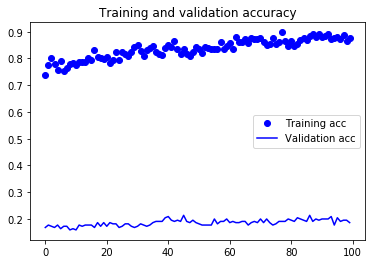

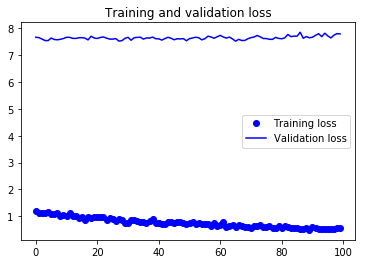

In [25]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
conv_base.summary()


We will unfreeze the layers in block 13 and block 14 

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == "block12_sepconv1_act":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Now we can start fine-tuning our network. We will do this with the RMSprop optimizer, using a very low learning rate. The reason for using a low learning rate is that we want to limit the magnitude of the modifications we make to the representations of the 3 layers that we are fine-tuning. Updates that are too large may harm these representations.

Now let's proceed with fine-tuning:


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

test_steps = int(round(train_image_count/batch_size))
print('test steps: ' + str(test_steps))
validation_steps = int(round(validation_image_count/batch_size))
print('validation_steps ' + str(validation_steps))

history = model.fit_generator(
      train_generator,
      steps_per_epoch=test_steps,
      epochs=300,
      validation_data=validation_generator,
      validation_steps=validation_steps)

test steps: 750
validation_steps 235
Epoch 1/300
750/750 [==============================] - 134s 178ms/step - loss: 4.0088 - acc: 0.4072 - val_loss: 10.4229 - val_acc: 0.1196
Epoch 2/300
750/750 [==============================] - 129s 173ms/step - loss: 3.9831 - acc: 0.4101 - val_loss: 10.5175 - val_acc: 0.1191
Epoch 3/300
750/750 [==============================] - 130s 173ms/step - loss: 3.9890 - acc: 0.4108 - val_loss: 10.5441 - val_acc: 0.1204
Epoch 4/300
750/750 [==============================] - 130s 173ms/step - loss: 3.9956 - acc: 0.4107 - val_loss: 10.6439 - val_acc: 0.1217
Epoch 5/300
750/750 [==============================] - 130s 173ms/step - loss: 3.9706 - acc: 0.4127 - val_loss: 10.5974 - val_acc: 0.1187
Epoch 6/300
750/750 [==============================] - 130s 173ms/step - loss: 3.9841 - acc: 0.4125 - val_loss: 10.4784 - val_acc: 0.1217
Epoch 7/300
750/750 [==============================] - 130s 174ms/step - loss: 3.9704 - acc: 0.4104 - val_loss: 10.4390 - val_acc: 0.12

Epoch 60/300
750/750 [==============================] - 130s 173ms/step - loss: 3.9200 - acc: 0.4207 - val_loss: 10.4431 - val_acc: 0.1213
Epoch 61/300
750/750 [==============================] - 130s 174ms/step - loss: 3.9328 - acc: 0.4245 - val_loss: 10.5767 - val_acc: 0.1234
Epoch 62/300
750/750 [==============================] - 130s 173ms/step - loss: 3.9173 - acc: 0.4207 - val_loss: 10.4632 - val_acc: 0.1238
Epoch 63/300
750/750 [==============================] - 129s 173ms/step - loss: 3.9061 - acc: 0.4264 - val_loss: 10.8219 - val_acc: 0.1209
Epoch 64/300
750/750 [==============================] - 130s 174ms/step - loss: 3.8796 - acc: 0.4240 - val_loss: 10.7142 - val_acc: 0.1230
Epoch 65/300
750/750 [==============================] - 130s 173ms/step - loss: 3.8971 - acc: 0.4245 - val_loss: 10.6120 - val_acc: 0.1255
Epoch 66/300
750/750 [==============================] - 130s 173ms/step - loss: 3.8845 - acc: 0.4237 - val_loss: 10.6017 - val_acc: 0.1221
Epoch 67/300
750/750 [=====

Epoch 119/300
750/750 [==============================] - 130s 173ms/step - loss: 3.8481 - acc: 0.4356 - val_loss: 10.6256 - val_acc: 0.1230
Epoch 120/300
750/750 [==============================] - 130s 173ms/step - loss: 3.8388 - acc: 0.4340 - val_loss: 10.6259 - val_acc: 0.1238
Epoch 121/300
750/750 [==============================] - 130s 173ms/step - loss: 3.8438 - acc: 0.4371 - val_loss: 10.8784 - val_acc: 0.1191
Epoch 122/300
750/750 [==============================] - 130s 173ms/step - loss: 3.8629 - acc: 0.4295 - val_loss: 10.6798 - val_acc: 0.1196
Epoch 123/300
750/750 [==============================] - 129s 173ms/step - loss: 3.8508 - acc: 0.4328 - val_loss: 10.9501 - val_acc: 0.1191
Epoch 124/300
750/750 [==============================] - 130s 173ms/step - loss: 3.8278 - acc: 0.4392 - val_loss: 10.6838 - val_acc: 0.1209
Epoch 125/300
750/750 [==============================] - 130s 173ms/step - loss: 3.8310 - acc: 0.4317 - val_loss: 10.8430 - val_acc: 0.1200
Epoch 126/300
750/75

750/750 [==============================] - 129s 172ms/step - loss: 3.7475 - acc: 0.4499 - val_loss: 10.8524 - val_acc: 0.1234
Epoch 236/300
750/750 [==============================] - 130s 173ms/step - loss: 3.7406 - acc: 0.4517 - val_loss: 10.8162 - val_acc: 0.1230
Epoch 237/300
750/750 [==============================] - 130s 173ms/step - loss: 3.7264 - acc: 0.4560 - val_loss: 10.9597 - val_acc: 0.1209
Epoch 238/300
750/750 [==============================] - 129s 172ms/step - loss: 3.7221 - acc: 0.4507 - val_loss: 10.7905 - val_acc: 0.1238
Epoch 239/300
750/750 [==============================] - 130s 173ms/step - loss: 3.7069 - acc: 0.4525 - val_loss: 10.7523 - val_acc: 0.1230
Epoch 240/300
750/750 [==============================] - 129s 172ms/step - loss: 3.7328 - acc: 0.4523 - val_loss: 11.0277 - val_acc: 0.1230
Epoch 241/300
750/750 [==============================] - 129s 173ms/step - loss: 3.7195 - acc: 0.4512 - val_loss: 10.9242 - val_acc: 0.1243
Epoch 242/300
750/750 [===========

In [ ]:
model.save('name_that_whale_700.h5')

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Making predictions for test data



In [61]:
cd ../

/home/ec2-user/SageMaker


In [62]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

home_dir = os.getcwd()
test_dir = os.path.join(home_dir, 'test/test_all')
test_list = os.listdir(test_dir)
test_count = len(test_list)
print(test_count)
ids_count = len(whale_ids)






15610


In [64]:
!pip install opencv-python

    100% |████████████████████████████████| 24.9MB 52kB/s  eta 0:00:01
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [78]:
import cv2
from keras.preprocessing import image

img_path = os.path.join(test_dir, test_list[0])
img = image.load_img(img_path, target_size = image_size)
x = image.img_to_array(img)
x /=255 # rescale to values between 0 and 1


#x_feature = conv_base.predict(x)
#label = model.predict(x_feature)
#print(label)

ValueError: Error when checking : expected input_2 to have 4 dimensions, but got array with shape (180, 180, 3)

In [63]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

## Want a tensor of length (test, # of whale ids)
'''
def predict_labels(directory):
    labels = np.zeros(shape=(test_count,ids_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=image_size,
        batch_size=batch_size,
        color_mode = 'rgb',
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        print('Generating predictions for image batch: ' + str(i)
        model.predict(inputs_batch)
        #labels_batch = model.predict(inputs_batch)
        labels[i * batch_size : (i + 1) * batch_size] = predicted_labels
        i += 1
        if i * batch_size >= test_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return  labels

test_labels = predict_labels(test_dir)
'''


#labels = np.zeros(shape=(test_count,ids_count))
#labels = model.predict(test_dir)

SyntaxError: invalid syntax (<ipython-input-63-81beb0e4fd24>, line 17)

In [ ]:


# We want to write something of the form: image_name pred_0 pred_2 ... pred_4
# Need to write a function that takes a label vector as input, and outputs an ordered list of 5 
# most probable whale_ids

# Need to get the index of the top 5 values of the label vector, then convert these into whale_ids

def get_ids(label_vec):
    ids = ''
    for i in range(5):
        max_value = max(label_vec)
        max_index = label_vec.index(max_value)
        ids += whale_ids[max_index]
        ids += ' '
        label_vec[max_index] = -1
    return ids
    

prediction = 'Image,Id \n'
for i in range(test_count):
    prediction += test_list[i]
    prediction += ','
    prediction += get_ids[test_labels[i]]
    prediction += '\n'

    
print(prediction)